In [1]:
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from matplotlib import pyplot as plt
import pandas as pd
import xarray as xr
import gcsfs
import datetime
import os
import numpy as np
from scipy.stats import rankdata
from scipy import stats


## Dipole Mode Index (DMI)

https://psl.noaa.gov/gcos_wgsp/Timeseries/DMI/

Intensity of the IOD is represented by anomalous SST gradient between the western equatorial Indian Ocean (50E-70E and 10S-10N) and the south eastern equatorial Indian Ocean (90E-110E and 10S-0N). This gradient is named as Dipole Mode Index (DMI). When the DMI is positive then, the phenomenon is refereed as the positive IOD and when it is negative, it is refereed as negative IOD.

As the original provider has changed how they update the index, we have decided to calculate it here using the HadISST1.1 SST dataset for the entire time period. Climatology is currently 1981-2010.

## Create DMI Index

In [2]:
url='https://psl.noaa.gov/gcos_wgsp/Timeseries/Data/dmi.had.long.data'
#file='nao.data'
#index_name='nao'

df=pd.read_table(url,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,
                 na_values=['-9999.000'])
df.drop(df.tail(7).index,inplace=True)
df = df.astype('float') #months 1-7 were read in as object, need to change to float

In [3]:
df.describe(include='all')

1           2           3           4           5           6   \
count  154.000000  154.000000  153.000000  153.000000  153.000000  153.000000   
mean    -0.174545   -0.172422   -0.160039   -0.189438   -0.206183   -0.198654   
std      0.261317    0.274004    0.260013    0.261283    0.273794    0.309310   
min     -0.732000   -0.868000   -0.752000   -0.862000   -0.802000   -0.944000   
25%     -0.380000   -0.359750   -0.327000   -0.345000   -0.415000   -0.396000   
50%     -0.183500   -0.164500   -0.151000   -0.207000   -0.207000   -0.190000   
75%     -0.003250    0.007500    0.026000   -0.015000   -0.059000   -0.006000   
max      0.525000    0.544000    0.458000    0.499000    0.544000    0.739000   

               7           8           9           10          11          12  
count  153.000000  153.000000  153.000000  153.000000  153.000000  153.000000  
mean    -0.300706   -0.291654   -0.371725   -0.364549   -0.254085   -0.219150  
std      0.365126    0.395021    0.447730    0.434188    0.352416    0.269501  
min     -1.083000   -1.260000   -1.634000   -1.167000   -0.906000   -0.812000  
25%     -0.548000   -0.522000   -0.678000   -0.638000   -0.474000   -0.385000  
50%     -0.354000   -0.321000   -0.377000   -0.428000   -0.289000   -0.248000  
75%     -0.129000   -0.024000   -0.091000   -0.155000   -0.100000   -0.053000  
max      0.708000    0.811000    0.893000    0.964000    1.279000    0.863000

In [4]:
start_date=str(df.index[0])+'-'+str(df.columns[0])+'-01'
end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-01'
print(start_date)

1870-1-01


In [5]:
dates=pd.date_range(start=start_date,end=end_date,freq='MS')

In [6]:
clim_index=df.T.unstack().values
clim_index=clim_index.astype('float32')

In [7]:
ds_index=xr.DataArray(clim_index,
                      coords={'time':dates},
                              dims=['time'])        
ds_index=ds_index.to_dataset(name='sst')
#ds_index

## Plot Monthly DMI and Precipataion Time Series

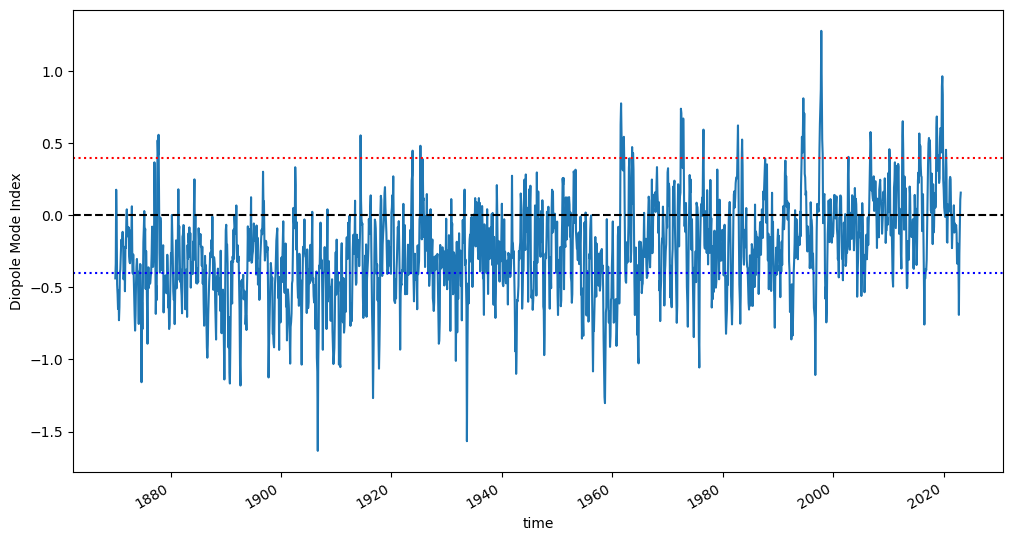

In [8]:
# plot the oni timeseries we just downloaded
fig, ax = plt.subplots(figsize=(12, 6))
ds_index.sst.plot(ax=ax)
#test1.plot(ax=ax)
ax.set_ylabel("Diopole Mode Index")
ax.axhline(y=0, linestyle="dashed", color="k")
ax.axhline(y=0.4, linestyle="dotted", color="r")
ax.axhline(y=-0.4, linestyle="dotted", color="b")

The IOD is a key driver of such interannual rainfall variability, describing differences in sea surface temperature (SST) anomaly between the western (50° E to 70° E, 10° S to 10° N) and eastern (90° E to 110° E, 10° S to 0° S) Indian Ocean. The positive IOD (signifying an SST anomaly difference of at least +0.4 °C for at least three months between the warmer west and cooler east) is linked with wetter short rains over Eastern Africa (Fig. 2a). During such phases, precipitation totals can be 2–3 times the long-term mean16, as seen in 1997, 2006, 2012, 2015 and 2019. In contrast, the negative IOD (defined by a sustained negative SST difference of at least 0.4 °C) is associated with weaker short rains17, resulting in 20–60% of the long-term mean rainfall, as evident during 1996, 1998, 2010 and 2016 (Fig. 2b).

https://www.nature.com/articles/s43017-023-00397-x#:~:text=Rainfall%20variability%20over%20Eastern%20Africa,%E2%80%93Julian%20Oscillation%20(MJO).

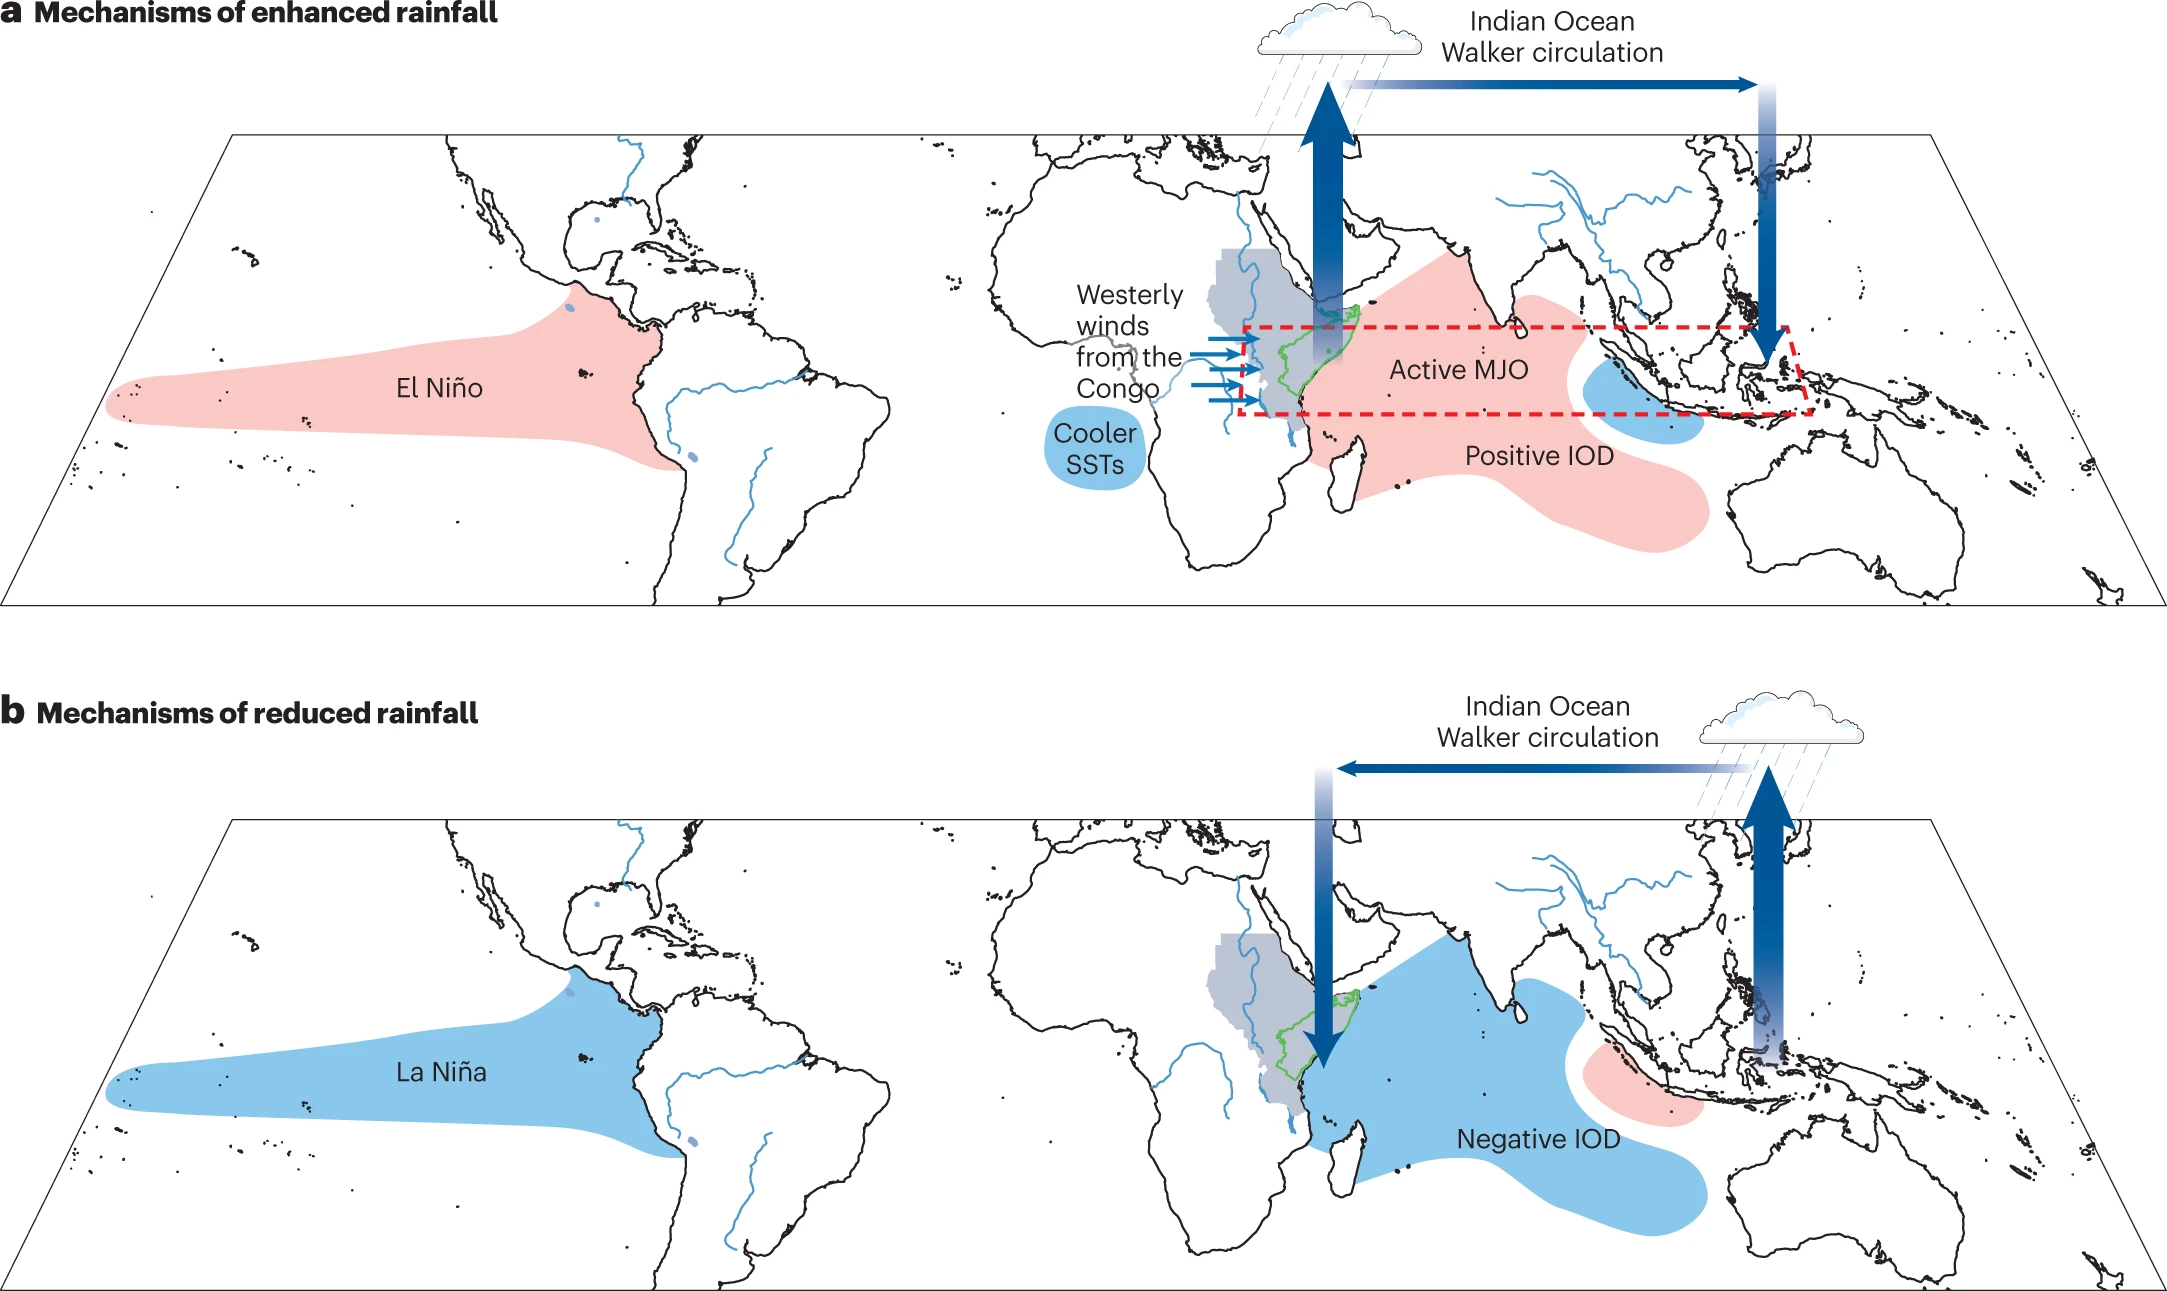

In [9]:
from PIL import Image
import requests
from io import BytesIO

url = "https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs43017-023-00397-x/MediaObjects/43017_2023_397_Fig2_HTML.png?as=webp"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.show()

pos IOD:  19
Neutral:  290
negative IOD:  51
[array(19), array(51), array(290)]


Text(0.5, 1.0, 'DMI 1981-2010; IOD (Threshold = 0.4 $\\degree$C)')

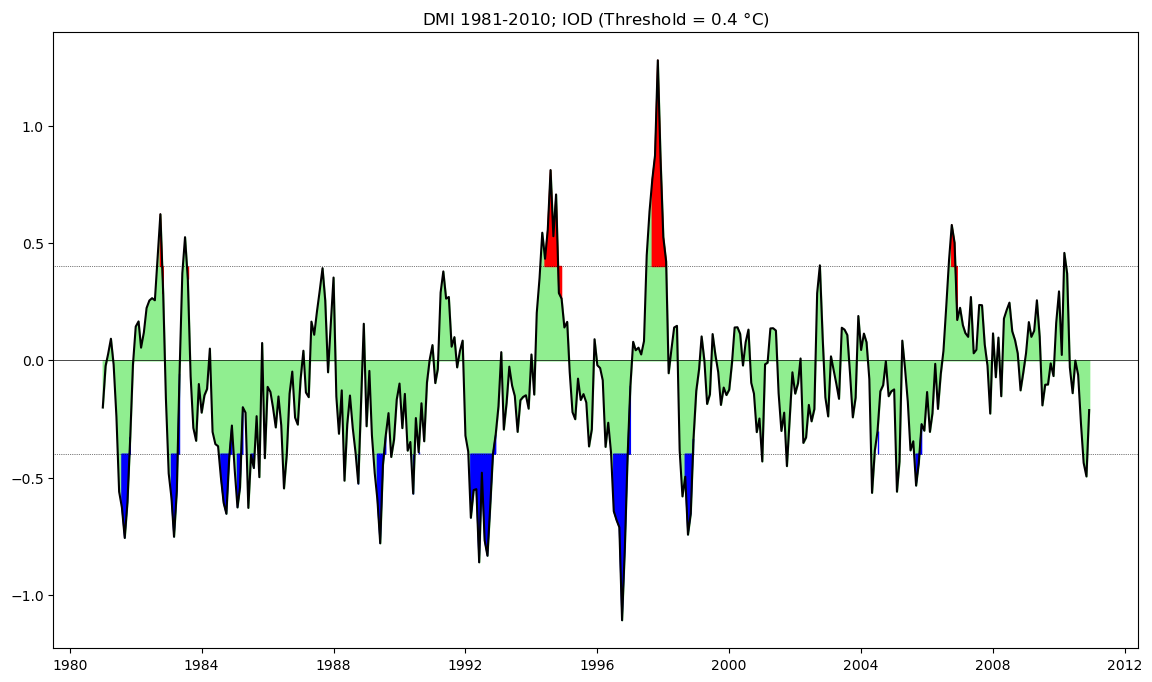

In [10]:
pos_iod=ds_index.sst.sel(time=slice('1981', '2010')).where(ds_index.sst.rolling(time=3).mean()>= 0.4)
neg_iod=ds_index.sst.sel(time=slice('1981', '2010')).where(ds_index.sst.rolling(time=3).mean() <= -0.4)
neutral=ds_index.sst.sel(time=slice('1981', '2010')).where(np.logical_and(ds_index.sst.rolling(time=3).mean()>-.4,
                                              ds_index.sst.rolling(time=3).mean()<.4))

print('pos IOD: ',pos_iod.count(dim='time').values)
print('Neutral: ',neutral.count(dim='time').values)
print('negative IOD: ',neg_iod.count(dim='time').values)

counts=[pos_iod.count(dim='time').values,
        neg_iod.count(dim='time').values,
        neutral.count(dim='time').values]
print(counts)
fig = plt.figure(figsize=(14, 8))
plt.plot(ds_index.time.sel(time=slice('1981', '2010')),ds_index.sst.sel(time=slice('1981', '2010')),'k')
plt.fill_between(ds_index.time.sel(time=slice('1981', '2010')).values,ds_index.sst.sel(time=slice('1981', '2010')),color='lightgreen')
plt.fill_between(ds_index.time.sel(time=slice('1981', '2010')).values,pos_iod,y2=.4,color='red')
plt.fill_between(ds_index.time.sel(time=slice('1981', '2010')).values,neg_iod,y2=-.4,color='blue')
plt.axhline(0,color='black',linewidth=0.5)
plt.axhline(.4,color='black',linewidth=0.5,linestyle='dotted')
plt.axhline(-.4,color='black',linewidth=0.5,linestyle='dotted') ;#ds_index

plt.title('DMI 1981-2010; IOD (Threshold = 0.4 $\degree$C)')

In [11]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_historical = df.query("table_id == 'Amon' & " +\
    "variable_id == 'pr' & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
print('Length of df_historical:', len(df_historical))
df_historical.head(3)

Length of df_historical: 54


activity_id institution_id     source_id experiment_id member_id  \
6263         CMIP      NOAA-GFDL      GFDL-CM4    historical  r1i1p1f1   
28995        CMIP           IPSL  IPSL-CM6A-LR    historical  r1i1p1f1   
32443        CMIP      NASA-GISS   GISS-E2-1-G    historical  r1i1p1f1   

      table_id variable_id grid_label  \
6263      Amon          pr        gr1   
28995     Amon          pr         gr   
32443     Amon          pr         gn   

                                                  zstore  dcpp_init_year  \
6263   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...             NaN   
28995  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...             NaN   
32443  gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...             NaN   

        version  
6263   20180701  
28995  20180803  
32443  20180827

# Create Composite DMI SST and CMIP6 CanESM5 Precipitation

In [12]:
model = 'CanESM5'

zstore_hist = df_historical.query(f"source_id == '{model}'").zstore.values[0]

In [13]:
gcs = gcsfs.GCSFileSystem(token='anon')
mapper = gcs.get_mapper(zstore_hist)
ds_hist= xr.open_zarr(mapper, consolidated = True)

# Convert to DATETIME
time coordinate is in "object" format, which we need to convert to datetime to be able to easily analyze the timeseries.

In [14]:
print('historical date range:', ds_hist.time[0].values, ' , ', ds_hist.time[-1].values) #first date end date

historical date range: 1850-01-16 12:00:00  ,  2014-12-16 12:00:00


In [15]:
start_time = pd.to_datetime(datetime.date(1850,1,1)) #set start date
time_new_ds_hist = [start_time + pd.DateOffset(months = x) for x in range(len(ds_hist.time))] #convert to date time

In [16]:
ds_hist = ds_hist.assign_coords(time = time_new_ds_hist) #assign converted datetime to dataset

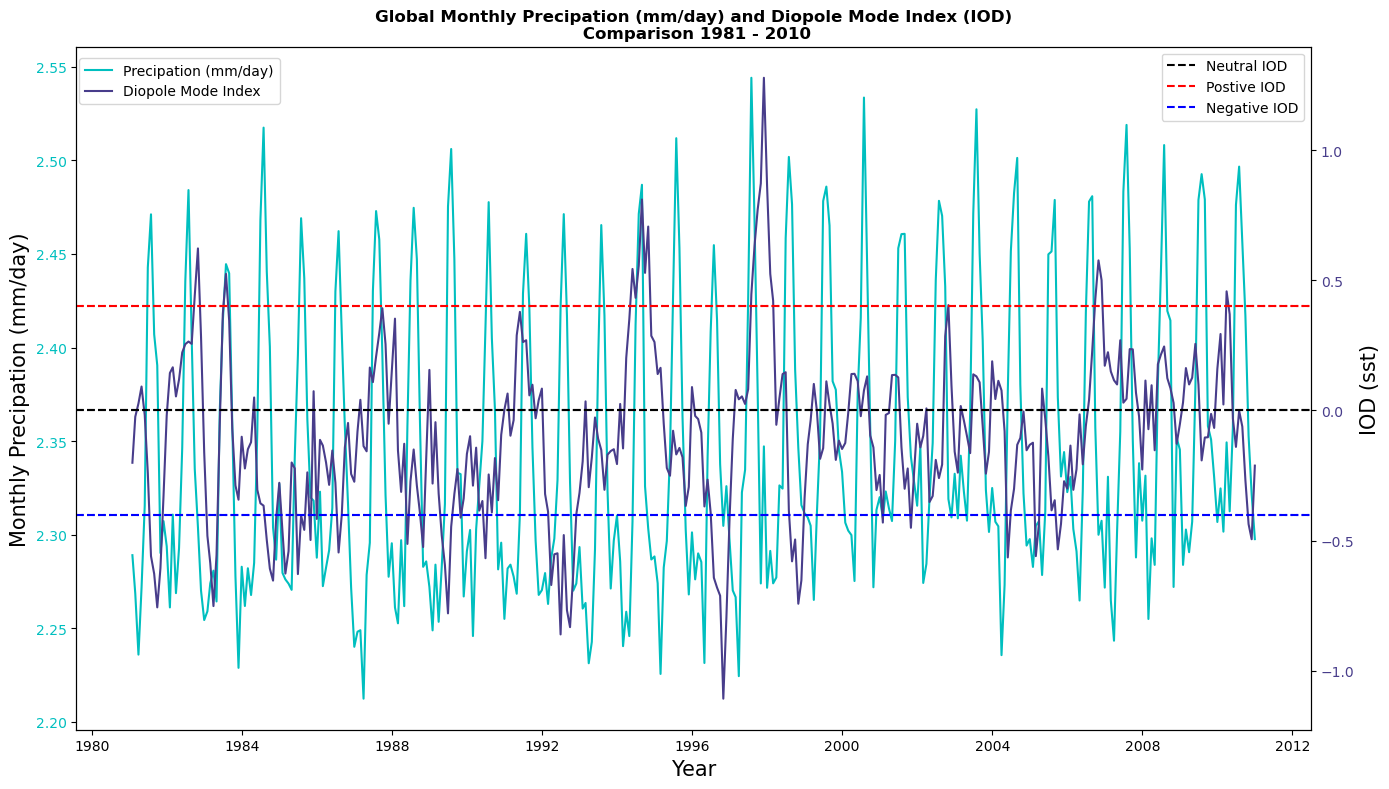

In [17]:
dmi_8110 = ds_index.sst.loc['1981':'2010'].resample(time='M').mean()
pr_global8110 = ds_hist.pr.loc['1981':'2010'].mean(dim=['lat','lon']).resample(time='M').mean()

x = dmi_8110.time
y3 = pr_global8110.values * 86400
y2 = dmi_8110

#plotting commands
fig, ax1 = plt.subplots(figsize=(14,8))

ax1.set_xlabel('Year')
ax1.set_ylabel('Monthly Precipation (mm/day)')
ax1.plot(x, y3, color='c', label='Precipation (mm/day)')
ax1.tick_params(axis='y', labelcolor='c')
ax1.yaxis.label.set(fontsize=15)
ax1.xaxis.label.set(fontsize=15)



ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel("IOD (sst)") # we already handled the x-label with ax1
ax2.plot(x, y2, color='darkslateblue', label='Diopole Mode Index')
ax2.tick_params(axis='y', labelcolor='darkslateblue')
ax2.yaxis.label.set(fontsize=15)


#fig.legend(loc='upper left')
fig.legend(bbox_to_anchor=(.06, .92), loc='upper left', borderaxespad=0)
ax1.set_title('Global Monthly Precipation (mm/day) and Diopole Mode Index (IOD)\n Comparison 1981 - 2010', fontweight='bold')
fig.tight_layout()

ax2.axhline(y=0, linestyle="dashed", color="k")
ax2.axhline(y=0.4, linestyle="dotted", color="r")
ax2.axhline(y=-0.4, linestyle="dotted", color="b")

handles, _ = ax2.get_legend_handles_labels()
handles.append(ax2.axhline(y=0, c='k', linestyle='dashed', label="Neutral IOD"))
handles.append(ax2.axhline(y=.4, c='red', linestyle='dashed', label="Postive IOD"))
handles.append(ax2.axhline(y=-.4, c='b', linestyle='dashed', label="Negative IOD"))



# Slice list to remove first handle
plt.legend(handles = handles[1:])
#plt.title('Eastern Africa Monthlu Precipation (mm/day) and Diopole Mode Index (IOD) Comparison 1981 - 2010', fontsize=20)



## Down Select to East Africa

bbox = left,bottom,right,top
bbox = min Longitude , min Latitude , max Longitude , max Latitude 

In [18]:
min_lon = -42.89#15.35
min_lat = -54.16#27.59
max_lon = 142.03#58.78
max_lat = 40.44#22.2
cropped_ds_ea = ds_hist.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon), time=slice('1981', '2010'))

# print(ds_hist['lat'].values)  # [52.771 52.471 52.171 51.871 51.571 51.271 50.971]
# print(ds_hist['lon'].values) # [3.927 4.227 4.527 4.827 5.127 5.427 5.727]

# #f2 = ds_hist.sel(longitude=slice(15.35, 58.78), latitude=slice(52.45, 51.5))  

# print(cropped_ds['lat'].values)  # [52.171 51.871 51.571]
# print(cropped_ds['lon'].values) # [4.527 4.827 5.127]

In [19]:
# calculate climatologcropped_ds_ea.pr.groupby("time.month").mean(dim="time")y using `.sel()` and `.groupby()` directly.
precip_clim = cropped_ds_ea.pr.groupby("time.month").mean(dim="time")#

da_anoms = cropped_ds_ea.pr.groupby("time.month") - precip_clim

/home/lcarte2/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 30 times more chunks
  return self.array[key]


## convert Precip to mm/day

In [20]:
da_anoms.values = da_anoms.values * 86400
#da_anoms

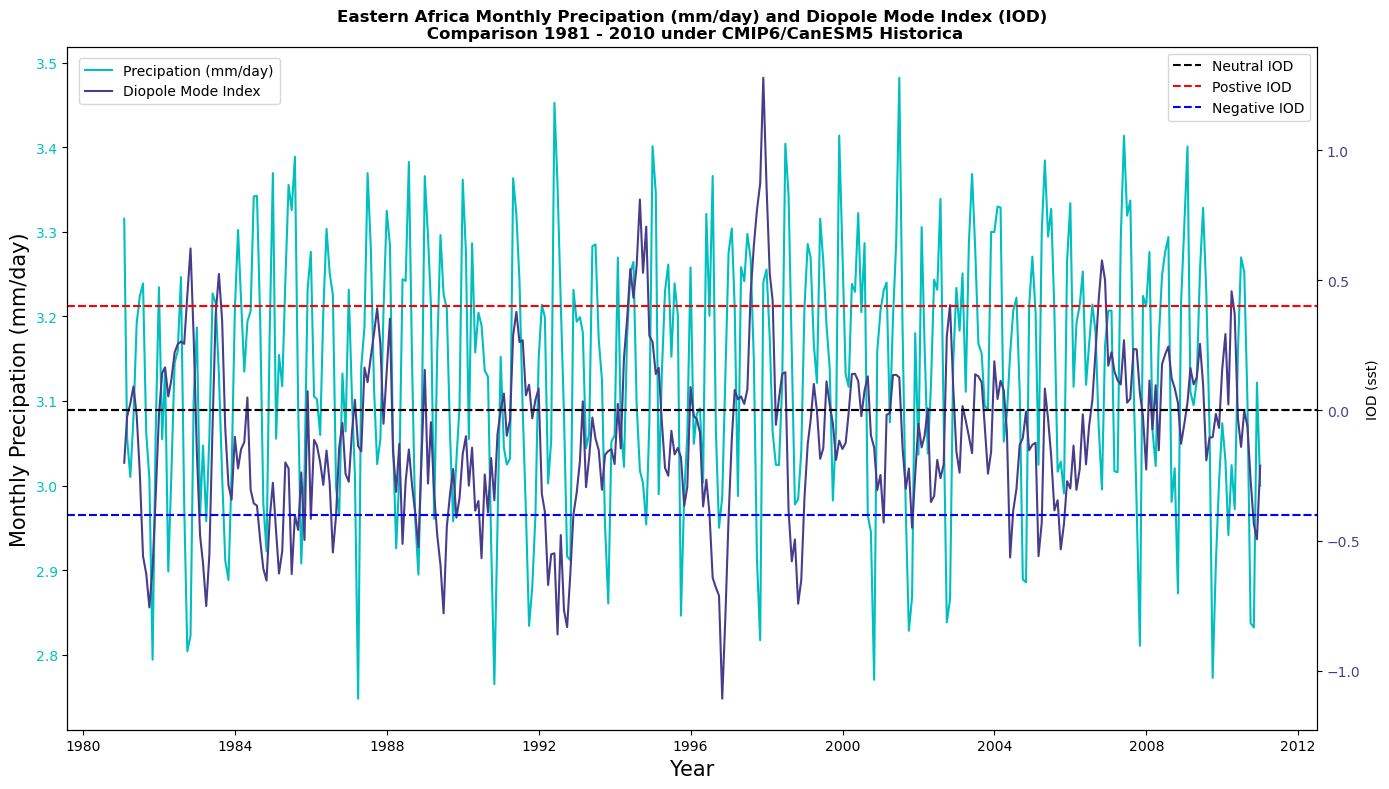

In [21]:
dmi_8110 = ds_index.sst.loc['1981':'2010'].resample(time='M').mean()
pr_eastafrica8110 = cropped_ds_ea.pr.loc['1981':'2010'].mean(dim=['lat','lon']).resample(time='M').mean()

x = dmi_8110.time
y1 = pr_eastafrica8110.values * 86400
y2 = dmi_8110

#plotting commands
fig, ax1 = plt.subplots(figsize=(14,8))

ax1.set_xlabel('Year')
ax1.set_ylabel('Monthly Precipation (mm/day)')
ax1.plot(x, y1, color='c', label='Precipation (mm/day)')
ax1.tick_params(axis='y', labelcolor='c')
ax1.yaxis.label.set(fontsize=15)
ax1.xaxis.label.set(fontsize=15)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel("IOD (sst)") # we already handled the x-label with ax1
ax2.plot(x, y2, color='darkslateblue', label='Diopole Mode Index')
ax2.tick_params(axis='y', labelcolor='darkslateblue')
ax2.xaxis.label.set(fontsize=15)


#fig.legend(loc='upper left')
fig.legend(bbox_to_anchor=(.06, .92), loc='upper left', borderaxespad=0)
ax1.set_title('Eastern Africa Monthly Precipation (mm/day) and Diopole Mode Index (IOD)\n Comparison 1981 - 2010 under CMIP6/CanESM5 Historica', fontweight='bold')
fig.tight_layout()

ax2.axhline(y=0, linestyle="dashed", color="k")
ax2.axhline(y=0.4, linestyle="dotted", color="r")
ax2.axhline(y=-0.4, linestyle="dotted", color="b")

handles, _ = ax2.get_legend_handles_labels()
handles.append(ax2.axhline(y=0, c='k', linestyle='dashed', label="Neutral IOD"))
handles.append(ax2.axhline(y=.4, c='red', linestyle='dashed', label="Postive IOD"))
handles.append(ax2.axhline(y=-.4, c='b', linestyle='dashed', label="Negative IOD"))



# Slice list to remove first handle
plt.legend(handles = handles[1:])
#plt.title('Eastern Africa Monthlu Precipation (mm/day) and Diopole Mode Index (IOD) Comparison 1981 - 2010', fontsize=20)



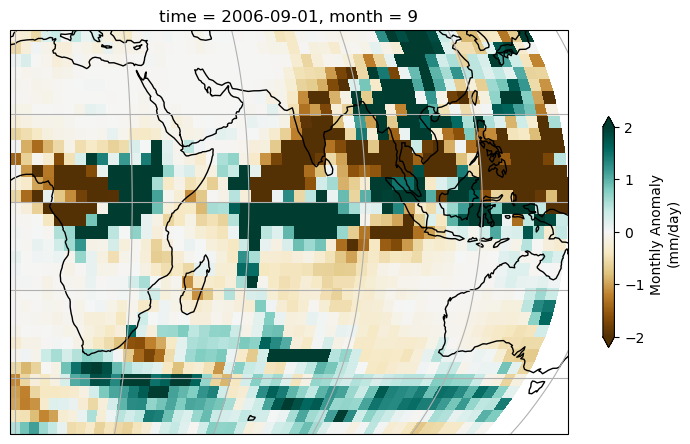

In [22]:
# initate plot
fig = plt.figure(figsize=(9, 6))

# set map projection
ax = plt.axes(projection=ccrs.Robinson())

# add coastal lines to indicate land/ocean
ax.coastlines()

# add grid lines for latitude and longitude
ax.gridlines()

# add the precipitation data for
da_anoms.sel(time="2006-09-01", method='nearest').plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    vmin=-2,
    vmax=2,
    cmap="BrBG",
    cbar_kwargs=dict(shrink=0.5, label="Monthly Anomaly \n(mm/day)"),
)

# Analyze Anomalies

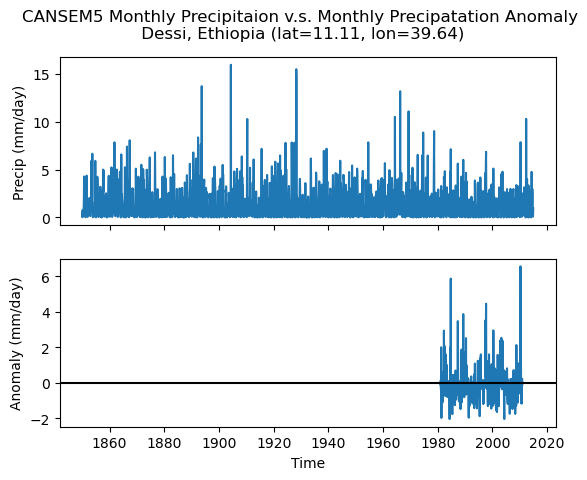

In [23]:
# set up two subplots that share the x-axis to compare monthly precipitation and monthly anomaly
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("CANSEM5 Monthly Precipitaion v.s. Monthly Precipatation Anomaly\n Dessi, Ethiopia (lat=11.11, lon=39.64)")
axs[0].plot(ds_hist.time, ds_hist.pr.sel(lat=11.11, lon=39.64, method="nearest").values * 86400)
axs[0].set_ylabel("Precip (mm/day)")
axs[1].plot(
    da_anoms.time, da_anoms.sel(lat=11.11, lon=39.64, method="nearest")
)
axs[1].set_ylabel("Anomaly (mm/day)")
axs[1].set_xlabel("Time")

# add horizontal line of y=0 for the anomaly subplot
axs[1].axhline(y=0, color="k", linestyle="-")

# calculate 12-month rolling mean for the selected location

In [24]:
# calculate 12-month rolling mean for the selected location
grid_month = da_anoms.sel(lat=11.11, lon=39.64, method="nearest")
grid_rolling = grid_month.rolling(time=12, center=True).mean()

Text(0.5, 1.0, 'CMIP6 CANMF5 Monthly Precipatation Anomaly\n Dessi, Ethiopia (lat=11.11, lon=39.64)')

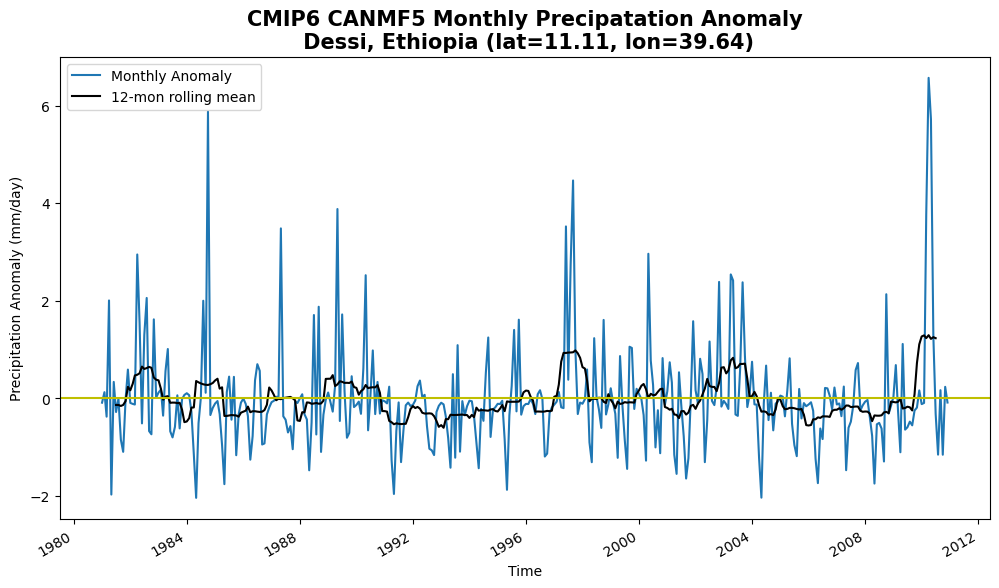

In [25]:
# create the time series plot of monthly anomaly
fig, ax = plt.subplots(figsize=(12, 6))
grid_month.plot(label="Monthly Anomaly", ax=ax)
grid_rolling.plot(color="k", label="12-mon rolling mean", ax=ax)
ax.axhline(y=0, color="y", linestyle="-")
ax.set_ylabel("Precipitation Anomaly (mm/day)")
ax.legend()
ax.set_xlabel("Time")
# remove the automatically generated title
ax.set_title("CMIP6 CANMF5 Monthly Precipatation Anomaly\n Dessi, Ethiopia (lat=11.11, lon=39.64)", fontsize=15, fontweight='bold')

## Calculate Global Mean Anomalies

When examining global-scale changes, it is common to aggregate global mean values from all grid cells. However, it is important to note that despite each grid having the same resolution of 2.5°×2.5°, they represent different areas on the Earth’s surface. Specifically, the same grid covers larger spatial areas in the tropics compared to the polar regions as discussed in the climate system overview day.

To address this issue, it is necessary to weight the values based on their respective surface areas. Unlink the model data you used previously, where you had the grid cell area available as a variable, for our gridded observations we will use weights based on the cosine of the latitude as this function takes into account the decreasing area towards the poles.

In [26]:
# calculate the weights using the latitude coordinates
weights = np.cos(np.deg2rad(da_anoms.lat))
weights.name = "weights"
weights

<xarray.DataArray 'weights' (lat: 33)>
array([0.62079573, 0.65822655, 0.69409662, 0.72832081, 0.76081786,
       0.79151066, 0.82032638, 0.84719663, 0.87205766, 0.89485048,
       0.91552101, 0.93402021, 0.9503042 , 0.96433433, 0.97607733,
       0.98550534, 0.99259598, 0.99733244, 0.99970349, 0.99970349,
       0.99733244, 0.99259598, 0.98550534, 0.97607733, 0.96433433,
       0.9503042 , 0.93402021, 0.91552101, 0.89485048, 0.87205766,
       0.84719663, 0.82032638, 0.79151066])
Coordinates:
  * lat      (lat) float64 -51.63 -48.84 -46.04 -43.25 ... 32.09 34.88 37.67
Attributes:
    axis:           Y
    bounds:         lat_bnds
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north

In [27]:
# calculate weighted global monthly mean
anom_weighted = da_anoms.weighted(weights)
global_weighted_mean = anom_weighted.mean(("lat", "lon"))
#global_weighted_mean

Text(0.5, 1.0, 'CMIP6 CANMF5 Global Monthly Precipatation Anomaly (Weighted)')

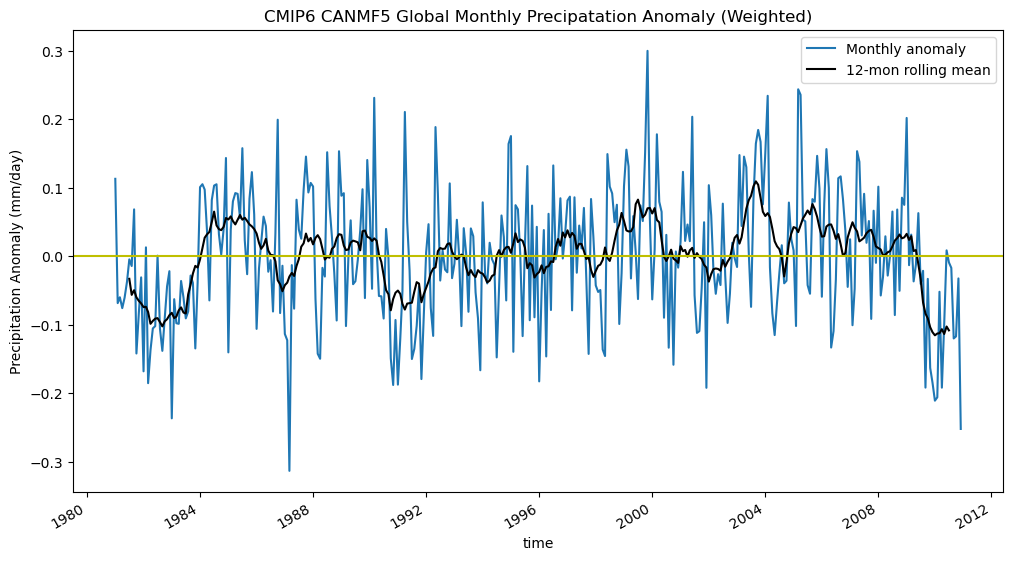

In [28]:
# create the time series plot of global weighted monthly anomaly
fig, ax = plt.subplots(figsize=(12, 6))
global_weighted_mean.plot(label="Monthly anomaly", ax=ax)
global_weighted_mean.rolling(time=12, center=True).mean(("lat", "lon")).plot(
    color="k", label="12-mon rolling mean", ax=ax
)
ax.axhline(y=0, color="y", linestyle="-")
ax.set_ylabel("Precipitation Anomaly (mm/day)")
ax.legend()

ax.set_title("CMIP6 CANMF5 Global Monthly Precipatation Anomaly (Weighted)")

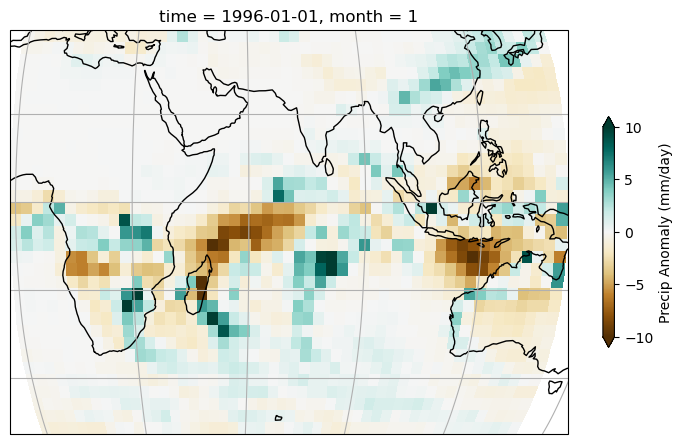

In [29]:
# select just data from 1998
data = da_anoms.sel(time="1996-01-01")

# initate plot
fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=54))
ax.coastlines()
ax.gridlines()
data.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    vmin=-10,
    vmax=10,
    cmap="BrBG",
    cbar_kwargs=dict(shrink=0.5, label="Precip Anomaly (mm/day)"),
)

# Correlation Analysis

Let’s look at several peak precip events in East Africa from 1980-2010; those include 1984-JASO, 1997-98 JASO, 2009-2010 MAMJ 

Let’s examine the seasonal precipitation anomaly pattern during this time period.

ref: https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/wea.3824

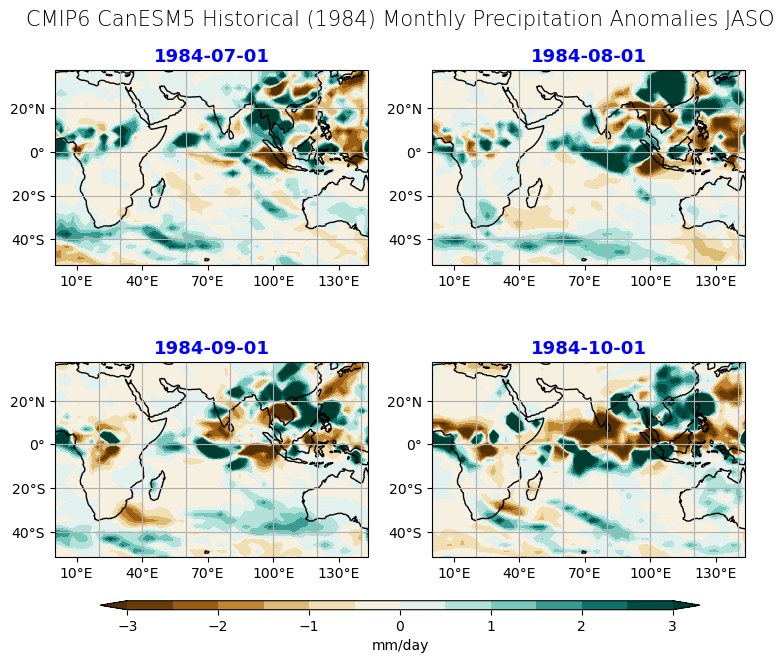

In [30]:

# define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=54)},
    figsize=(12, 7.5),
    sharex=True,
    sharey=True,
)
clevs=np.arange(-3,3.5,0.5)
# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs = axs.flatten()
# First, We will develop a land mask data array that we can use to mask out the nan values:
landmask = da_anoms.sum(dim='time')>0
# loop over selected months (Jan, Apr, Jul, Oct)
for i, month in enumerate(["1984-07-01", "1984-08-01", "1984-09-01", "1984-10-01"]):
    # draw the coastines and major gridline for each subplot
    axs[i].coastlines()
    axs[i].gridlines()
    #ax = plt.axes(projection = ccrs.Mercator())
    #axs.add_feature(cf.coastlines)
            # Select the season
    data = da_anoms.sel(time=month)

    # Add the cyclic point
    data,lons = add_cyclic_point(data,coord=da_anoms[i]['lon'])

    # Contour plot
    cs = axs[i].contourf(lons,da_anoms[i]['lat'],
                         data,
                         clevs,
                         transform=ccrs.PlateCarree(), 
                         cmap='BrBG',
                         extend='both'
                        )

       # Longitude labels
    axs[i].set_xticks(np.arange(-50,181,30), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    axs[i].set_yticks(np.arange(-60,61,20), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    
        # Title each subplot with the name of the month
    axs[i].set_title(month, fontsize = 13, fontweight = 'bold', color = 'b')

        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.2, right=0.8,
                    wspace=.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')

# Add a big title at the top
plt.suptitle(f'CMIP6 {model} Historical (1984) Monthly Precipitation Anomalies JASO', fontsize=15, fontweight=15) ;



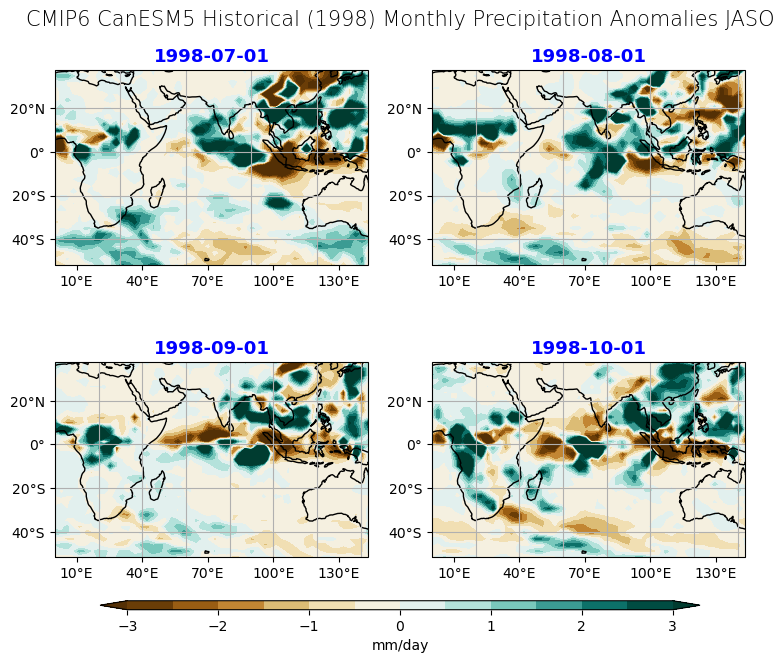

In [31]:
# define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=54)},
    figsize=(12, 7.5),
    sharex=True,
    sharey=True,
)
clevs=np.arange(-3,3.5,0.5)
# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs = axs.flatten()
# First, We will develop a land mask data array that we can use to mask out the nan values:
landmask = da_anoms.sum(dim='time')>0
# loop over selected months (Jan, Apr, Jul, Oct)
for i, month in enumerate(["1998-07-01", "1998-08-01", "1998-09-01", "1998-10-01"]):
    # draw the coastines and major gridline for each subplot
    axs[i].coastlines()
    axs[i].gridlines()
    #ax = plt.axes(projection = ccrs.Mercator())
    #axs.add_feature(cf.coastlines)
            # Select the season
    data = da_anoms.sel(time=month)

    # Add the cyclic point
    data,lons = add_cyclic_point(data,coord=da_anoms[i]['lon'])

    # Contour plot
    cs = axs[i].contourf(lons,da_anoms[i]['lat'],
                         data,
                         clevs,
                         transform=ccrs.PlateCarree(), 
                         cmap='BrBG',
                         extend='both'
                        )

       # Longitude labels
    axs[i].set_xticks(np.arange(-50,181,30), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    axs[i].set_yticks(np.arange(-60,61,20), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    
        # Title each subplot with the name of the month
    axs[i].set_title(month, fontsize = 13, fontweight = 'bold', color = 'b')

        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.2, right=0.8,
                    wspace=.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')

# Add a big title at the top
plt.suptitle(f'CMIP6 {model} Historical (1998) Monthly Precipitation Anomalies JASO', fontsize=15, fontweight=15) ;


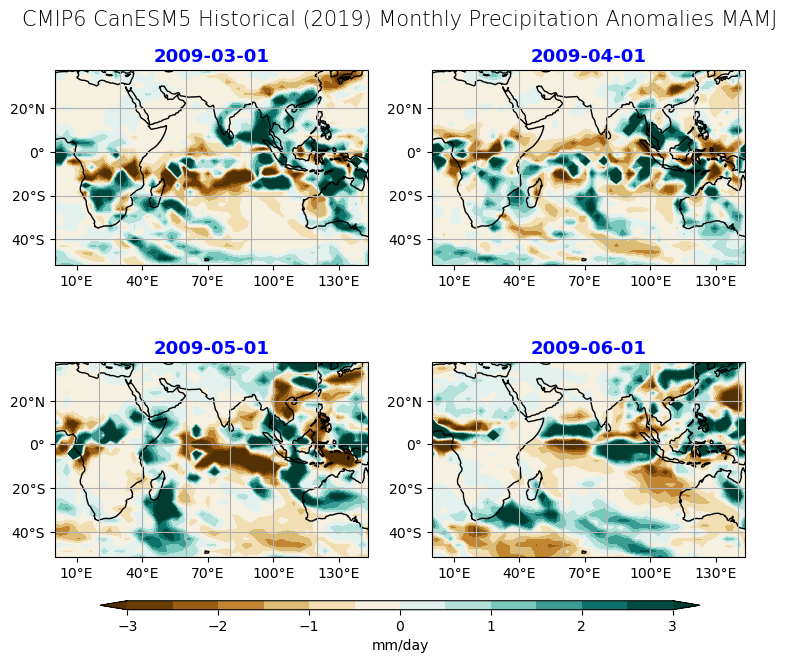

In [32]:
import cartopy.feature as cf
import calendar # We'll use this library to easily add month name to subplot titles.

# define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=54)},
    figsize=(12, 7.5),
    sharex=True,
    sharey=True,
)
clevs=np.arange(-3,3.5,0.5)
# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs = axs.flatten()
# First, We will develop a land mask data array that we can use to mask out the nan values:
landmask = da_anoms.sum(dim='time')>0
# loop over selected months (Jan, Apr, Jul, Oct)
for i, month in enumerate(["2009-03-01", "2009-04-01", "2009-05-01", "2009-06-01"]):
    # draw the coastines and major gridline for each subplot
    axs[i].coastlines()
    axs[i].gridlines()
    #ax = plt.axes(projection = ccrs.Mercator())
    #axs.add_feature(cf.coastlines)
            # Select the season
    data = da_anoms.sel(time=month)

    # Add the cyclic point
    data,lons = add_cyclic_point(data,coord=da_anoms[i]['lon'])

    # Contour plot
    cs = axs[i].contourf(lons,da_anoms[i]['lat'],
                         data,
                         clevs,
                         transform=ccrs.PlateCarree(), 
                         cmap='BrBG',
                         extend='both'
                        )

       # Longitude labels
    axs[i].set_xticks(np.arange(-50,181,30), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    axs[i].set_yticks(np.arange(-60,61,20), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    
        # Title each subplot with the name of the month
    axs[i].set_title(month, fontsize = 13, fontweight = 'bold', color = 'b')

        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.2, right=0.8,
                    wspace=.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')

# Add a big title at the top
plt.suptitle(f'CMIP6 {model} Historical (2019) Monthly Precipitation Anomalies MAMJ', fontsize=15, fontweight=15) ;

Quantify the correlation between the IOD (DMI) and the precipitation anomaly for a region of our interest.

Let’s use DMI region as an example to calculate the correlation berween precipitation and IOD.

Note: DMI is from western (50° E to 70° E, 10° S to 10° N) and eastern (90° E to 110° E, 10° S to 0° S) Indian Ocean

In [33]:
iod_min_lon = -30#15.35
iod_min_lat = -25#54.16#27.59
iod_max_lon = 120.84#.03#58.78
iod_max_lat = 23#40.44#22.2
precip_DMI = da_anoms.sel(lat=slice(iod_min_lat, iod_max_lat), 
                         lon=slice(iod_min_lon, iod_max_lon), 
                         time=slice('1981', '2010'))
#precip_DMI

In [34]:
# calculate regional mean of the precipitation anomaly
precip_DMI_mean = precip_DMI.mean(("lat", "lon"))

# extract DMI value for the common period (ending at 2022-12-01)
dmi = ds_index.sel(time=slice("1981", "2010"))

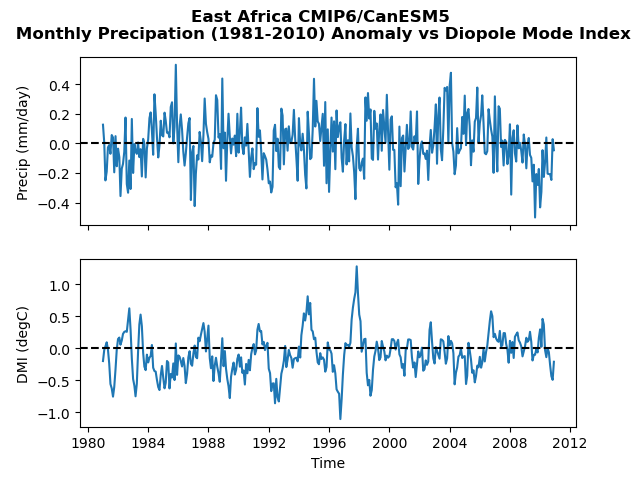

In [35]:
# set up two subplots that share the x-axis to compare precipitation anomaly and ONI index
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("GPCP Precipitaion Anomaly v.s. Diopole Index")
fig.suptitle(f'East Africa CMIP6/CanESM5\n Monthly Precipation (1981-2010) Anomaly vs Diopole Mode Index', fontweight='bold')

axs[0].plot(precip_DMI_mean.time, precip_DMI_mean.values)
axs[0].set_ylabel("Precip (mm/day)")
axs[0].axhline(y=0, color="k", linestyle="dashed")
axs[1].plot(dmi.time, dmi.sst)
axs[1].set_ylabel("DMI (degC)")
axs[1].set_xlabel("Time")
axs[1].axhline(y=0, color="k", linestyle="dashed")

Text(0, 0.5, 'Precipitation Anomaly (mm/day)')

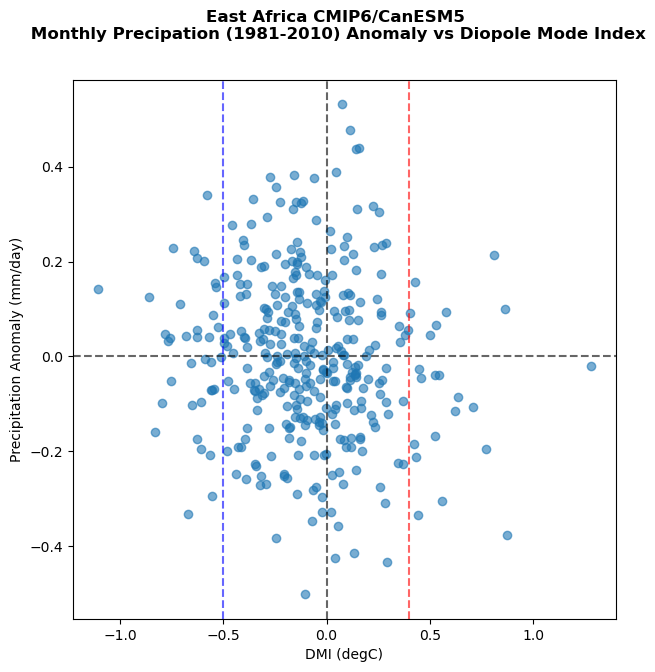

In [36]:
# set up scatter plot
fig, ax = plt.subplots(figsize=(7, 7))
#fig.suptitle("GPCP Precipitaion Anomaly v.s. Diopole Mode Index")
fig.suptitle(f'East Africa CMIP6/CanESM5\n Monthly Precipation (1981-2010) Anomaly vs Diopole Mode Index', fontweight='bold')

ax.scatter(dmi.sst, precip_DMI_mean, alpha=0.6)

# add horizontal and vertical lines of 0 values
ax.axhline(y=0, linestyle="dashed", color="k", alpha=0.6)
ax.axvline(x=0, linestyle="dashed", color="k", alpha=0.6)
ax.axvline(x=0.4, linestyle="dashed", color="r", alpha=0.6)  # El Nino threshold
ax.axvline(x=-0.5, linestyle="dashed", color="b", alpha=0.6)  # La Nina threshold
ax.set_xlabel("DMI (degC)")
ax.set_ylabel("Precipitation Anomaly (mm/day)")

### It is important to look at precipiation when sst is +/- .04 so we do more slicing to have better correlation understanding to support statistical significance analysis

In [37]:
# Positive IOD Data, logically index to keep IOD values above 0.4
positive_iod_sst = dmi.sst[dmi.sst > 0.4]
positive_iod_precip = precip_DMI_mean[dmi.sst > 0.4]

# Negative IOD Data, logically index to keep IOD values below -0.4
negative_iod_sst = dmi.sst[dmi.sst < -0.4]
negative_iod_precip = precip_DMI_mean[dmi.sst < -0.4]

Text(0, 0.5, 'Precipitation Anomaly (mm/day)')

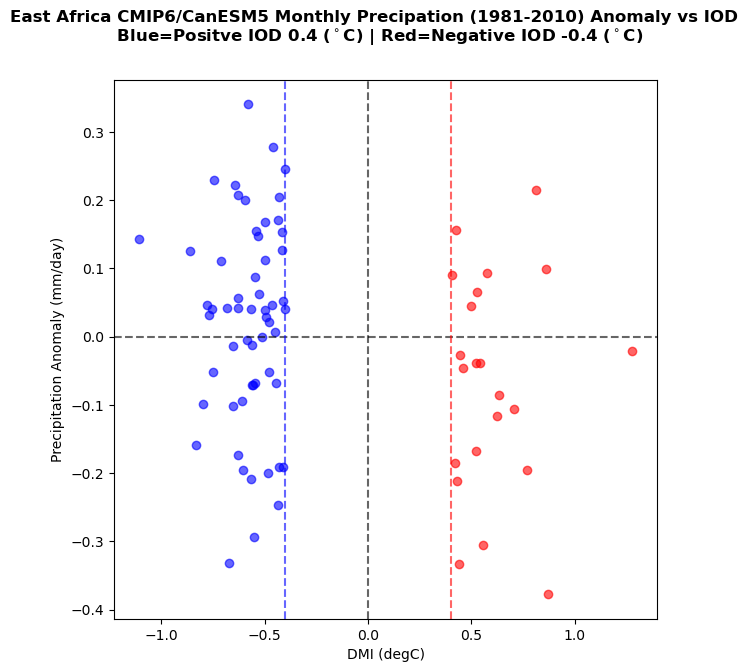

In [38]:
# set up scatter plot for just El Nino and La Nina phases
fig, ax = plt.subplots(figsize=(7, 7))
#fig.suptitle("GPCP Precipitaion Anomaly v.s. Diopole Mode Index")
fig.suptitle(f'East Africa CMIP6/CanESM5 Monthly Precipation (1981-2010) Anomaly vs IOD \n Blue=Positve IOD 0.4 ($^\circ$C) | Red=Negative IOD -0.4 ($^\circ$C)', fontweight='bold')

ax.scatter(positive_iod_sst, positive_iod_precip, c="r", alpha=0.6)
ax.scatter(negative_iod_sst, negative_iod_precip, c="b", alpha=0.6)

# add horizontal and vertical lines of 0 values
ax.axhline(y=0, linestyle="dashed", color="k", alpha=0.6)
ax.axvline(x=0, linestyle="dashed", color="k", alpha=0.6)
ax.axvline(x=0.4, linestyle="dashed", color="r", alpha=0.6)  # El Nino threshold
ax.axvline(x=-0.4, linestyle="dashed", color="b", alpha=0.6)  # La Nina threshold
ax.set_xlabel("DMI (degC)")
ax.set_ylabel("Precipitation Anomaly (mm/day)")

## Create Composite of Precip and DMI

In [39]:
posIOD_precip = da_anoms.sel(time=pos_iod.dropna(dim='time')['time'], method='nearest').mean(dim='time')
negIOD_precip = da_anoms.sel(time=neg_iod.dropna(dim='time')['time'], method='nearest').mean(dim='time')
neutralIOD_precip = da_anoms.sel(time=neutral.dropna(dim='time')['time'], method='nearest').mean(dim='time')

comp_precip = [posIOD_precip,negIOD_precip,neutralIOD_precip]


Text(0.5, 0.98, 'Composite  Between DMI(IOD) and Precipatation (1981-2010) \n Based on CMIP6/CanESM5 Historical 1 \n Positve IOD 0.4 ($^\\circ$C) | Negative IOD -0.4 ($^\\circ$C)')

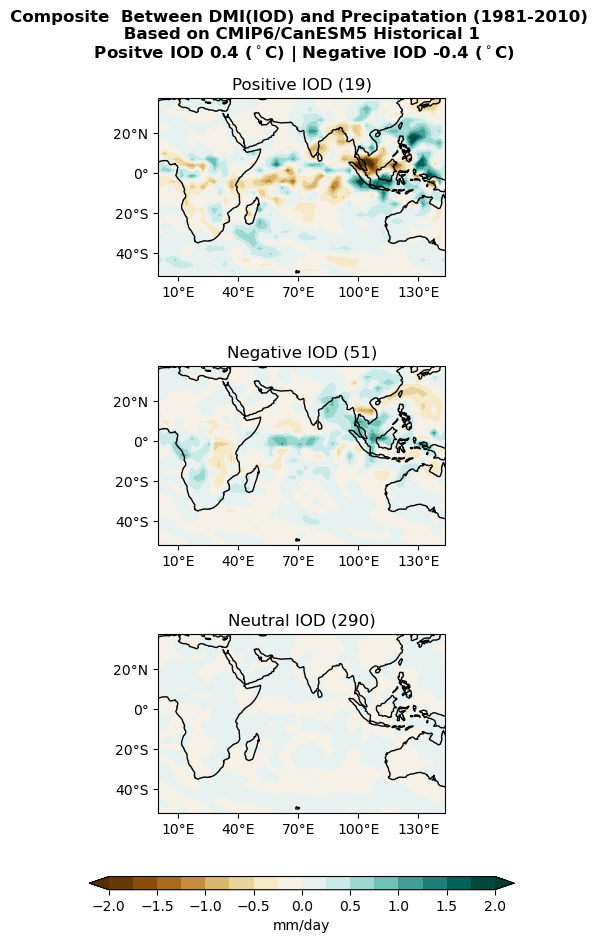

In [40]:


labels=['Positive IOD','Negative IOD', 'Neutral IOD']
clevs = np.arange(-2.0,2.1,0.25)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=54)},
                        figsize=(8.5,11),
                        sharex=True,
                        sharey=True,)

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the seasons and plot
for i,iod in enumerate(comp_precip):

        # Select the season
        data = comp_precip[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=comp_precip[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,comp_precip[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-50,181,30), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-60,61,20), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i]+' ('+str(counts[i])+')')

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')

# Add a big title at the top
fig.suptitle(f'Composite  Between DMI(IOD) and Precipatation (1981-2010) \n Based on CMIP6/CanESM5 Historical 1 \n Positve IOD 0.4 ($^\circ$C) | Negative IOD -0.4 ($^\circ$C)', fontweight='bold')


In [41]:
diff_precip=[posIOD_precip-neutralIOD_precip, 
             negIOD_precip-neutralIOD_precip]

Text(0.5, 0.98, 'Composite Difference Between DMI(IOD) and Precipatation (1981-2010) \n Based on CMIP6/CanESM5 Historical 1 \n Left: Positve IOD 0.4 ($^\\circ$C) | Right: Negative IOD -0.4 ($^\\circ$C)')

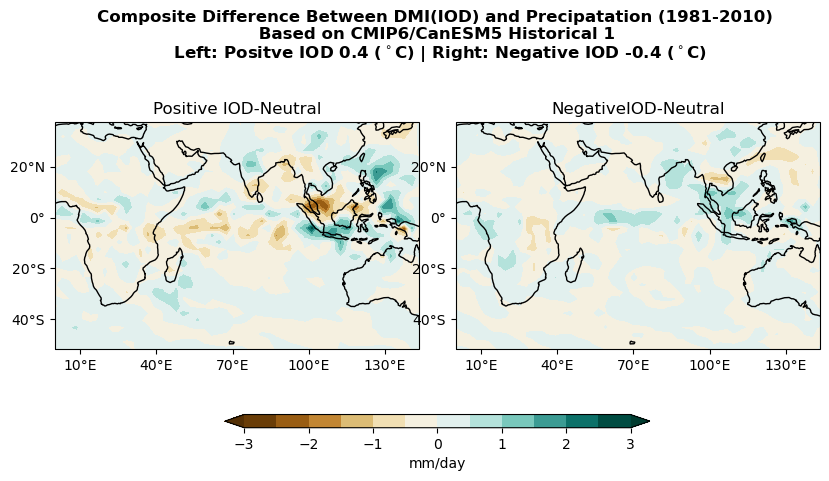

In [42]:
labels=['Positive IOD-Neutral','NegativeIOD-Neutral']
clevs=np.arange(-3,3.5,0.5)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11),
                        gridspec_kw={'width_ratios': [1, 1], },
                        sharex=True,
                        sharey=True,)

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs = axs.flatten()

#Loop over all of the seasons and plot
for i,dmi in enumerate(diff_precip):

        # Select the season
        data = diff_precip[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=diff_precip[i]['lon'])

        # Contour plot
        cs = axs[i].contourf(lons,diff_precip[i]['lat'],data,clevs,
                          transform=ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-50,181,30), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-60,61,20), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=1.35, left=0.05, right=0.95,
                   wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.6, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm/day')

# Add a big title at the top
fig.suptitle(f'Composite Difference Between DMI(IOD) and Precipatation (1981-2010) \n Based on CMIP6/CanESM5 Historical 1 \n Left: Positve IOD 0.4 ($^\circ$C) | Right: Negative IOD -0.4 ($^\circ$C)', fontweight='bold')


## Correlation and Statistical Significance

### Correlation Coefficient

The standard formula for calculating correlation (also sometimes called Pearson's Correlation) is:

$r_{x,y}=\frac{cov(x,y)}{\sigma_x\sigma_y}$, where

$ cov(x,y)=\sum_{i=1}^{n} (x_i-\bar{x}) (y_i-\bar{y})$

It has a range of -1 to 1.
* A value of 1 means the two timeseries are perfectly correlated
* A value of -1 means they are perfectly anti-correlated
* A value of 0 means they are uncorrelated

Typically, in climate, we perform these calculations on anomalies, 
so we have already removed the means $(\bar{x},\bar{y})$, 
so our correlation equation reduces to:

$r_{x,y}=\frac{\sum_{i=1}^{n} x_i y_i} {\sigma_x\sigma_y}$

In our example:

* $x$ refers to the DMI index
* $y$ refers to our Precip anomaly at a point
* $n$ refers to the number of times (months).   

In [43]:
# correlation for positive IOD
pos_iod_r, pos_iod_p = stats.pearsonr(positive_iod_sst, positive_iod_precip)

print("Positive IOD - Corr Coef: " + str(pos_iod_r) + ", p-val: " + str(pos_iod_p))

# correlation for negative IOD
neg_iod_r, neg_iod_p = stats.pearsonr(negative_iod_sst, negative_iod_precip)

print("Negative IOD - Corr Coef: " + str(neg_iod_r) + ", p-val: " + str(neg_iod_p))

Positive IOD - Corr Coef: 0.029225723429738296, p-val: 0.8972736373960254
Negative IOD - Corr Coef: 0.005410490991690206, p-val: 0.9681380877371203


In [44]:

pos_iod_r_map = xr.corr(positive_iod_sst.sel(time=slice('1981', '2010')),da_anoms,dim='time')
neg_iod_r_map = xr.corr(negative_iod_sst.sel(time=slice('1981', '2010')),da_anoms,dim='time')

pos_neg_coor = [pos_iod_r_map, neg_iod_r_map]

Text(0.5, 0.98, 'Correlation Between DMI(IOD) and Precipatation (1981-2010) \n Based on CMIP6/CanESM5 Historical 1 \n Left - Positve IOD 0.4 ($^\\circ$C) Right: -0.4 ($^\\circ$C)')

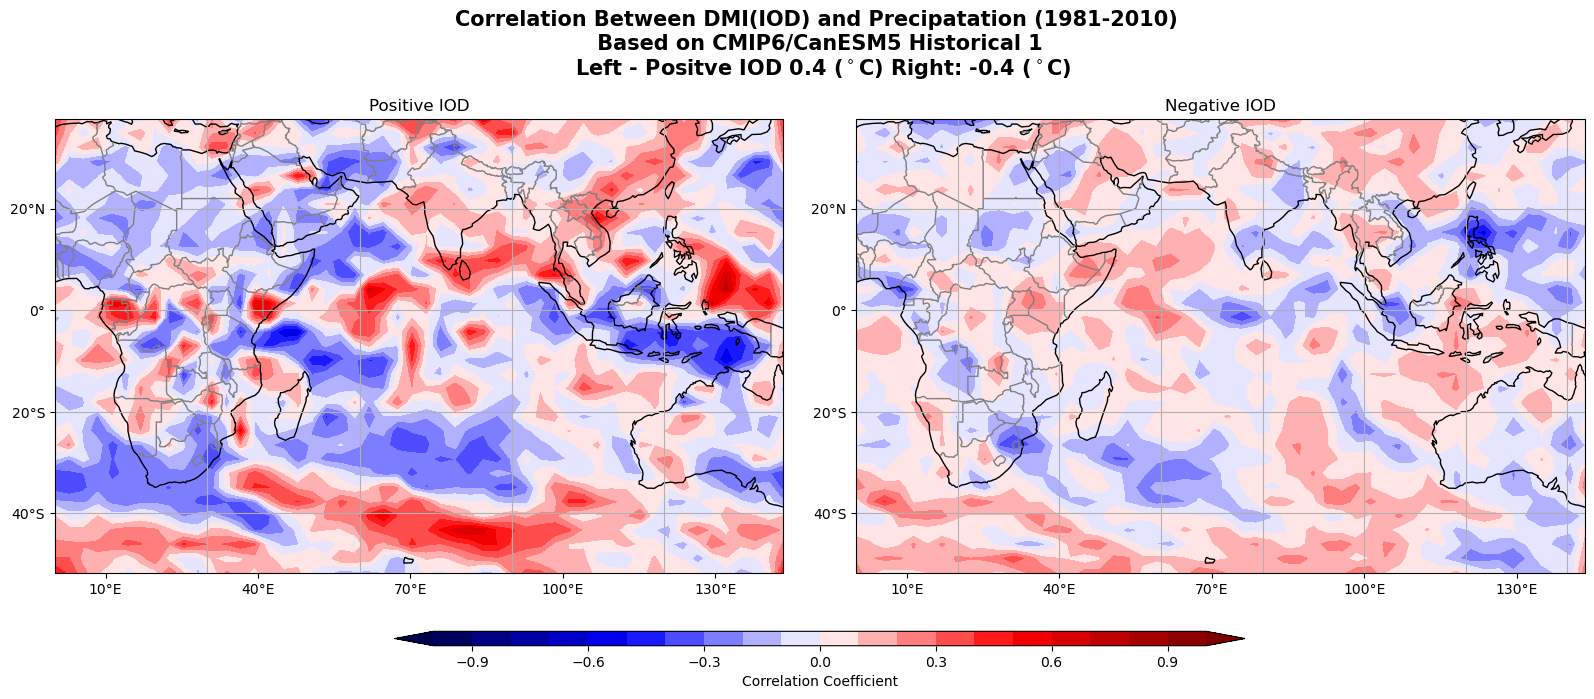

In [45]:
import cartopy.feature as cfeature

country_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='50m',
    facecolor='none')

labels=['Positive IOD','Negative IOD']
clevs=np.arange(-1,1.1,0.1)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=54)},
                        figsize=(17,12),
                        gridspec_kw={'width_ratios': [1, 1], },
                        sharex=True,
                        sharey=True,
                       )

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
#axs = axs.flatten()

#Loop over all of the seasons and plot
for i,dmi in enumerate(pos_neg_coor):

        # Select the season
        data = pos_neg_coor[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=pos_neg_coor[i]['lon'])

        # Contour plot
        cs = axs[i].contourf(lons,
                             pos_neg_coor[i]['lat'],
                             data,
                             clevs,
                             transform=ccrs.PlateCarree(),
                             cmap='seismic',
                             extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-50,181,30), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-60,61,20), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the IOD
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        #Draw the gridlines for each subplot
        axs[i].gridlines()
        
        axs[i].add_feature(country_borders, edgecolor='gray')

        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=1.2, left=0.05, right=0.95,
                   wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.45, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Correlation Coefficient')
#fig.tight_layout()
# Add a big title at the top
fig.suptitle(f'Correlation Between DMI(IOD) and Precipatation (1981-2010) \n Based on CMIP6/CanESM5 Historical 1 \n Left - Positve IOD 0.4 ($^\circ$C) Right: -0.4 ($^\circ$C)',  fontsize=15, fontweight='bold')

             
             #Correlation between Dipole Mode Index and CMIP6 {model} Monthly Precipitation Anomalies from 1981-2010', fontsize=15, fontweight='bold') ;

### Interpreting our Correlation

* Red areas indicate that the precipitation increases when IOD increases and precipattion decreaeses when IOD decreases.
* Blue area indicate the oppposite: precipitation increases when IOD decreases and precipation decreases when IOD increases. 
* The values near zero indicate no relationship between precipitation anomalies and IOD. 

-------------
## Statistical Significance of a Correlation

The purpose of statistical significance is to ensure we don't make conclusions about results obtained by random chance. 
We want to be sure that when we find a correlation, there is in fact a likely relationship.

Let's calculate statistical significance of the correlation using the `stats` package and another correlation function: `pearsonr`.

This function calculates both the correlation coefficient and the p-value indicating it the % chance that we could be wrong about it being different from zero.

First, let's look at the help for `pearsonr`


In [48]:
import time
from scipy.stats import pearsonr
nx=len(da_anoms['lon'])
ny=len(da_anoms['lat'])

p_array=np.zeros((ny,nx))
r_array=np.zeros((ny,nx))

t_start = time.perf_counter()
for i in range(nx):
    for j in range(ny):
        r,p = pearsonr(ds_index.sst.sel(time=slice('1981', '2010')),da_anoms[:,j,i],)
        r_array[j,i] = r
        p_array[j,i] = p
#r_array.shape
print(f"{time.perf_counter()-t_start:0.2f} s")

2.41 s


### Obtain p values

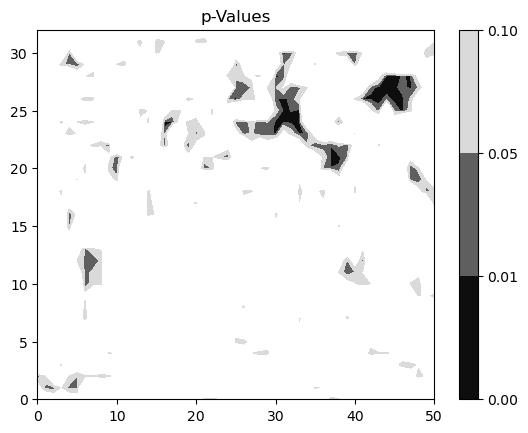

In [49]:
plt.contourf(p_array,[0,0.01,0.05,0.1],cmap='Greys_r')
plt.title("p-Values")
plt.colorbar() ;

Text(0.5, 1.0, 'Correlation Between DMI(IOD) and Precipatation (1981-2010) \n Based on CMIP6/CanESM5 Historical 1 \n p < 0.01 has been dotted')

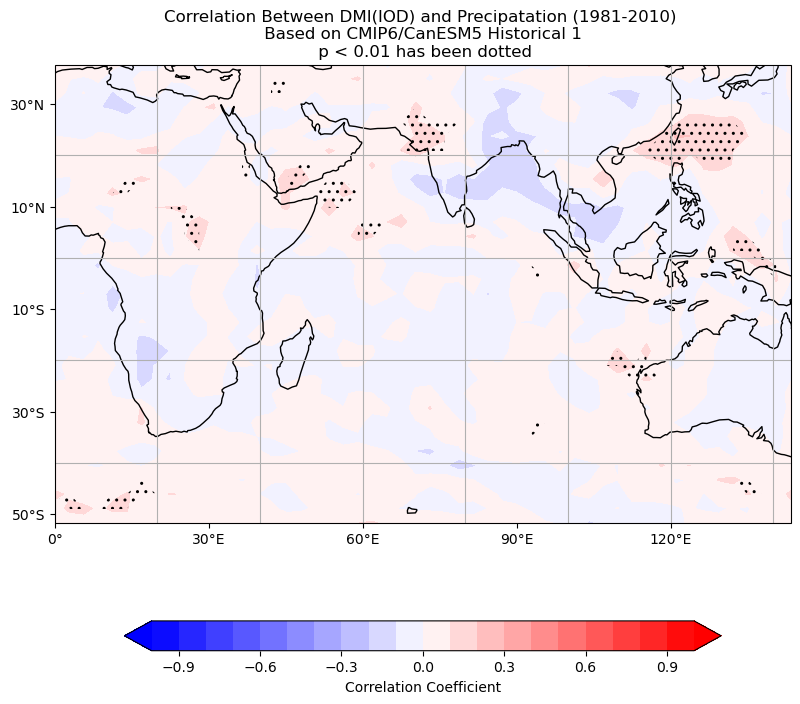

In [53]:

mask_sig=np.where(p_array<0.15,r_array,np.nan)

clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=54))

# Add cyclic point
data=r_array
data,lon=add_cyclic_point(data,coord=da_anoms['lon'])
mask_data,lons=add_cyclic_point(mask_sig,coord=da_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,da_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='bwr',extend='both')

ax.contourf(lon,da_anoms['lat'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=[None, '..'],extend='both',alpha=0)

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

def label_latlon(ax,lons,lats):
    """ Add tick labels """
    # Define the xticks for longtitude
    ax.set_xticks(lons,crs=ccrs.PlateCarree())
    lon_formatter=cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    # Define ytick for latitude
    ax.set_yticks(lats,crs=ccrs.PlateCarree())
    lat_formatter=cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

    return

label_latlon(ax,np.arange(0,135,30),np.arange(-50,40,20))

# ax.set_xticks(np.arange(-50,181,30), crs=ccrs.PlateCarree())
# lon_formatter = cticker.LongitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)

# # Latitude labels
# ax.set_yticks(np.arange(-60,61,20), crs=ccrs.PlateCarree())
# lat_formatter = cticker.LatitudeFormatter()
# ax.yaxis.set_major_formatter(lon_formatter)


# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation Between DMI(IOD) and Precipatation (1981-2010) \n Based on CMIP6/CanESM5 Historical 1 \n p < 0.01 has been dotted')
